## ADS508 Data Science With Cloud Computing - Team 4 - Week 6



### Data Preprocessing 

In [123]:
!pip install --disable-pip-version-check -q tensorflow==2.8.1
!pip install --disable-pip-version-check -q transformers==4.46.0
!pip install protobuf==3.20.*
!pip install --disable-pip-version-check -q tensorflow==2.8.1
!pip install rapidfuzz

import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer
import sagemaker
from sagemaker.automl.automl import AutoML
from sagemaker.session import Session
from sagemaker import get_execution_role
import boto3
from rapidfuzz import fuzz, process

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.1
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.1


In [66]:
import boto3
import pandas as pd
from io import StringIO, BytesIO

# Define S3 
s3_bucket = "team4bucket-mmm"
s3_key = "Patent_Data_Kaggle/Patent_Data.csv" 

# Initialize S3 client
s3 = boto3.client('s3')

# Load CSV file
response = s3.get_object(Bucket=s3_bucket, Key=s3_key)
data = response['Body'].read().decode('utf-8')

# Convert to Pandas DataFrame
patent_data = pd.read_csv(StringIO(data))

# Remove rows where the "product" column is null or NaN - Not Applied
#patent_data = patent_data[patent_data["product"].notna()]

# Display the first few rows
print(patent_data.head())

  flag        case_no  filed_date  filing_year  status  \
0   DC  5:00-cv-20003  2000-01-03         2000  Closed   
1   DC  1:00-cv-00001  2000-01-03         2000  Closed   
2   DC  1:00-cv-00004  2000-01-03         2000  Closed   
3   DC  1:00-cv-00023  2000-01-03         2000  Closed   
4   DC  1:00-cv-00010  2000-01-03         2000  Closed   

                                 court                         plaintiff  \
0   California Northern District Court                  Powis Parker Inc   
1              Delaware District Court        Becton Dickinson & Company   
2  District Of Columbia District Court      CAROL BROMER|Nicholas Bromer   
3     Illinois Northern District Court      Hearthware Home Products Inc   
4     New York Southern District Court  Lex Computer and Management Corp   

  parent_company 3rd_funded  \
0            NaN        NaN   
1            NaN        NaN   
2            NaN        NaN   
3            NaN        NaN   
4            NaN        NaN   

       

/tmp/ipykernel_754/808220364.py:17: DtypeWarning: Columns (13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_data = pd.read_csv(StringIO(data))


In [67]:
# List and count unique court names
court_counts = patent_data["court"].value_counts(dropna=False)

print("Court name counts:")
print(court_counts)

Court name counts:
court
Texas Eastern District Court                                      13710
Delaware District Court                                           10520
California Central District Court                                  6558
California Northern District Court                                 4593
Illinois Northern District Court                                   3720
                                                                  ...  
Illinois Northern District  Court                                     1
Texas Eastern District Cour                                           1
Dakota Southern District Court                                        1
U.S. District CourtDistrict of South Dakota (Western Division)        1
Carolina Southern District Court                                      1
Name: count, Length: 104, dtype: int64


In [68]:
# Handle missing values in court
patent_data['court'] = patent_data['court'].fillna("Unknown")

# Extract Unique court names
unique_courts = patent_data['court'].dropna().unique()

# Create frequency table for courts
court_counts = patent_data['court'].value_counts()

# Set a similarity threshold (e.g., 90 out of 100)
similarity_threshold = 90

# Store mappings
court_mapping = {}

# Loop through unique court names
for court in unique_courts:
    # Skip if already mapped
    if court in court_mapping:
        continue
    
    # Find best match from high-frequency courts
    best_match = process.extractOne(court, court_counts.index, scorer=fuzz.ratio)
    
    if best_match and best_match[1] >= similarity_threshold:
        matched_name = best_match[0]
        if court != matched_name:
            court_mapping[court] = matched_name

# Apply the mapping by replacing similar court names
patent_data['court'] = patent_data['court'].replace(court_mapping)

#### Clean entity type and cause of action columns 

In [69]:
patent_data['entity_type'].unique()

array(['Operating Company', 'NPE (Individual)',
       'NPE (Patent Assertion Entity)', 'NPE (Small Company)',
       'University', nan, 'Gov/NGO/Non-Profit', 'Gov'], dtype=object)

In [70]:
# Create the mapping dictionary
entity_mapping = {
    "Operating Company": "Operating Company",
    "NPE (Individual)": "NPE - Individual",
    "NPE (Patent Assertion Entity)": "NPE - PAE",
    "NPE (Small Company)": "NPE - Small Company",
    "University": "University",
    "Gov/NGO/Non-Profit": "Government/Non-Profit",
    "Gov": "Government"
}

# Apply the mapping and fill NaN with 'Unknown'
patent_data['entity_type'] = patent_data['entity_type'].map(entity_mapping).fillna('Unknown')

In [71]:
print("Null values per column:")
print(patent_data.isna().sum())

Null values per column:
flag                        0
case_no                     0
filed_date                  0
filing_year                 0
status                      0
court                       0
plaintiff                  50
parent_company          52022
3rd_funded              67876
defendant                  81
patents                  8447
cause_of_action          1154
entity_type                 0
sme_annotation          62716
industry                52402
judge                   39027
closed_date              5576
markman_hearing_date    78300
product                 51423
dtype: int64


In [72]:
# Fill missing values 
patent_data = patent_data.assign(
    markman_hearing_date=patent_data['markman_hearing_date'].fillna("Not Provided"),
    product=patent_data['product'].fillna("Unknown"),
    judge=patent_data['judge'].fillna("Not Available"),
    court=patent_data['court'].fillna("Unknown"),
    plaintiff=patent_data['plaintiff'].fillna("Unknown"),
    defendant=patent_data['defendant'].fillna("Unknown"),
    industry=patent_data['industry'].fillna("Not Available"),
    sme_annotation=patent_data['sme_annotation'].fillna("Not Available")
)
patent_data['cause_of_action'] = patent_data['cause_of_action'].fillna('unknown')

In [73]:
print("Null values per column:")
print(patent_data.isna().sum())

Null values per column:
flag                        0
case_no                     0
filed_date                  0
filing_year                 0
status                      0
court                       0
plaintiff                   0
parent_company          52022
3rd_funded              67876
defendant                   0
patents                  8447
cause_of_action             0
entity_type                 0
sme_annotation              0
industry                    0
judge                       0
closed_date              5576
markman_hearing_date        0
product                     0
dtype: int64


In [74]:
# Ensure date columns are datetime
patent_data['filed_date'] = pd.to_datetime(patent_data['filed_date'], errors='coerce')
patent_data['closed_date'] = pd.to_datetime(patent_data['closed_date'], errors='coerce')

# Create case_duration in days
patent_data['case_duration'] = (patent_data['closed_date'] - patent_data['filed_date']).dt.days

# Replace missing or invalid durations with -1
patent_data['case_duration'] = patent_data['case_duration'].apply(lambda x: x if pd.notnull(x) and x >= 0 else -1)

In [75]:
patent_data['cause_of_action'].unique()

array(['Patent', 'Antitrust\n Patent',
       'Copyright\n Patent\n Antitrust\n Trade Secret\n Contracts',
       'Securities\n Patent', 'Contracts\n Patent\n Trade Secret',
       'Antitrust\n Contracts\n Patent', 'Patent\n Trademark',
       'Contracts\n Patent', 'Contracts\n Patent\n Trademark',
       'Patent\n Trade Secret', 'Antitrust\n Patent\n Trademark',
       'Trade Secret\n Antitrust\n Patent\n Trademark\n Contracts',
       'Copyright\n Trade Secret\n Patent\n Trademark\n Contracts',
       'Patent\n Contracts', 'Antitrust\n Contracts\n Patent\n Trademark',
       'Copyright\n Patent\n Trademark', 'Antitrust\n Patent\n Contracts',
       'Copyright\n Patent', 'Antitrust\n Copyright\n Patent\n Trademark',
       'Trademark\n Copyright\n Patent\n Trade Secret',
       'Antitrust\n Contracts\n Copyright\n Patent',
       'Trademark\n Patent\n Trade Secret',
       'Trademark\n Contracts\n Patent\n Trade Secret',
       'Contracts\n Trademark\n Trade Secret\n Antitrust\n Paten

In [76]:
# Clean cause of action column

# make lowercase and strip whitespace 
patent_data['cause_of_action'] = patent_data['cause_of_action'].str.lower().str.strip()

# Replace Newlines \n and | with Commas
patent_data['cause_of_action'] = patent_data['cause_of_action'].str.replace(r'\n|\|', ',', regex=True)

# correct typos 
patent_data['cause_of_action'] = patent_data['cause_of_action'].replace({
    'infringment': 'infringement',
    'inventership': 'inventorship',
    'pt patent infringement': 'patent infringement',
    'nr notice of removal': 'notice of removal',
    'ej fed question enforcement of judgment': 'fed question enforcement of judgment',
    'dj declaratory judgment': 'declaratory judgment',
    'motquash': 'motion to quash',
    'la trademark infringement lanham act': 'trademark infringement lanham act'
})

# create new column 'primary_cause' and extract the first entry from cause of action column
patent_data['primary_cause'] = patent_data['cause_of_action'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# Create a set of standardized categories
categories = {
    'patent': 'patent',
    'patent infringement': 'patent infringement',
    'trademark': 'trademark',
    'trademark infringement': 'trademark infringement',
    'copyright': 'copyright',
    'antitrust': 'antitrust',
    'trade secret': 'trade secret',
    'breach of contract': 'breach of contract',
    'declaratory judgment': 'declaratory judgment',
    'infringement': 'infringement',
    'false patent marking': 'false patent marking',
    'correction of inventorship': 'correction of inventorship',
    'patent interference': 'patent interference',
    'unfair competition lanham act': 'lanham act',
}

def map_category(cause):
    if pd.isnull(cause):
        return 'unknown'
    for key in categories.keys():
        if key in cause:
            return categories[key]
    return 'other'

patent_data['standard_cause'] = patent_data['cause_of_action'].apply(map_category)

Note: Here a new column 'standard_cause' was created that holds the standardized categories of the 'cause_of_action' column. A reduced set list good for analyzing.

In [77]:
patent_data['standard_cause'].unique()

array(['patent', 'infringement', 'other', 'declaratory judgment',
       'breach of contract', 'correction of inventorship', 'trademark',
       'lanham act', 'trade secret', 'copyright', 'antitrust'],
      dtype=object)

In [78]:
#clean_data_patent = patent_data.dropna()
clean_data_patent = patent_data

In [79]:
# Display DataFrame
patent_data.head()

,flag,case_no,filed_date,filing_year,status,court,plaintiff,parent_company,3rd_funded,defendant,...,entity_type,sme_annotation,industry,judge,closed_date,markman_hearing_date,product,case_duration,primary_cause,standard_cause
0,DC,5:00-cv-20003,2000-01-03,2000,Closed,California Northern District Court,Powis Parker Inc,NaN,NaN,"Label Plus, Inc.",...,Operating Company,Not Available,Not Available,Ronald M. Whyte,2000-04-21,Not Provided,Unknown,109.0,patent,patent
1,DC,1:00-cv-00001,2000-01-03,2000,Closed,Delaware District Court,Becton Dickinson & Company,NaN,NaN,"Inverness Medical Technology, Inc.|Selfcare Inc.",...,Operating Company,Not Available,Not Available,Joseph James Farnan Jr.,2002-08-19,Not Provided,Unknown,959.0,patent,patent
2,DC,1:00-cv-00004,2000-01-03,2000,Closed,District Of Columbia District Court,CAROL BROMER|Nicholas Bromer,NaN,NaN,"Handcuffs Inc|J.C. Penney Corporation, Inc.|Ma...",...,NPE - Individual,Not Available,Not Available,Henry Harold Kennedy Jr.,2000-10-24,Not Provided,Unknown,295.0,patent,patent
3,DC,1:00-cv-00023,2000-01-03,2000,Closed,Illinois Northern District Court,Hearthware Home Products Inc,NaN,NaN,Eugene Song|Imex Corporation,...,Operating Company,Not Available,Not Available,John Francis Grady,2000-03-02,Not Provided,Unknown,59.0,patent,patent
4,DC,1:00-cv-00010,2000-01-03,2000,Closed,New York Southern District Court,Lex Computer and Management Corp,NaN,NaN,"Datavision Computer Video|Ulead Systems, Inc",...,Operating Company,Not Available,Not Available,Loretta A. Preska,2001-10-31,Not Provided,Unknown,667.0,patent,patent


#### Add number patent

In [80]:
# Remove rows where patents are null
patent_data = patent_data.dropna(subset=['patents'])

# Or if you want to be more explicit about different null values
patent_data = patent_data[patent_data['patents'].notna() & (patent_data['patents'] != '')]

# Then apply the patent counting function
def count_patents(patents):
    # If patents is NaN or empty, return 0
    if pd.isna(patents) or patents == '':
        return 0
    
    # Convert to string to handle different input types
    patents_str = str(patents)
    
    # Count the number of '|' and add 1 to get the patent count
    # For "|5682318|6010156", this will return 2
    return patents_str.count('|') + 1

# Apply the function
patent_data['number_patent'] = patent_data['patents'].apply(count_patents)
patent_data['patent'] = patent_data['patents']# Convert number_patent to string
patent_data['number_patent'] = patent_data['number_patent'].astype(str)
patent_data = patent_data.rename(columns={'case_no': 'case_id'})
patent_data['case_id'] = patent_data['case_id'].astype(str)

patent_data.head()

,flag,case_id,filed_date,filing_year,status,court,plaintiff,parent_company,3rd_funded,defendant,...,industry,judge,closed_date,markman_hearing_date,product,case_duration,primary_cause,standard_cause,number_patent,patent
1,DC,1:00-cv-00001,2000-01-03,2000,Closed,Delaware District Court,Becton Dickinson & Company,NaN,NaN,"Inverness Medical Technology, Inc.|Selfcare Inc.",...,Not Available,Joseph James Farnan Jr.,2002-08-19,Not Provided,Unknown,959.0,patent,patent,1,4703017
5,DC,1:00-cv-00003,2000-01-03,2000,Closed,Texas Southern District Court,Daniel E Davis,NaN,NaN,Favelle Favco Cranes USA INC|Favelle Favco Hol...,...,Not Available,Hilda G. Tagle,2001-08-13,Not Provided,Unknown,588.0,patent,patent,1,6003252
7,DC,3:00-cv-00004,2000-01-04,2000,Closed,Connecticut District Court,Dymo-Costar Corporation,NaN,NaN,Seiko Instruments USA Inc.,...,Not Available,Janet C. Hall,2000-12-28,Not Provided,Unknown,359.0,patent,patent,2,5682318|6010156
10,DC,1:00-cv-10004,2000-01-04,2000,Closed,Massachusetts District Court,Nutrition 21 LLC,NaN,NaN,"American International Chemical, Inc.",...,Not Available,Patti B. Saris,2000-11-28,Not Provided,Unknown,329.0,patent,patent,1,RE33988
21,DC,3:00-cv-00032,2000-01-05,2000,Closed,Oregon District Court,Kai USA LTD,NaN,NaN,"Great Neck Saw Manufacturers, Inc.",...,Not Available,Ancer Lee Haggerty,2000-05-18,Not Provided,Unknown,134.0,patent,patent,1,6006385


In [81]:
!pip install matplotlib

In [82]:
# Define the categorization function
def categorize_duration(duration):
    if duration < 80:
        return "Low"
    elif 80 <= duration < 270:   
        return "Medium"
    else:
        return "High"

# Apply the categorization function
df=patent_data
df["duration_type"] = df["case_duration"].apply(categorize_duration)
print(df["duration_type"].value_counts())

duration_type
High      29744
Medium    26601
Low       14749
Name: count, dtype: int64


duration_type
High      29744
Medium    26601
Low       14749
Name: count, dtype: int64


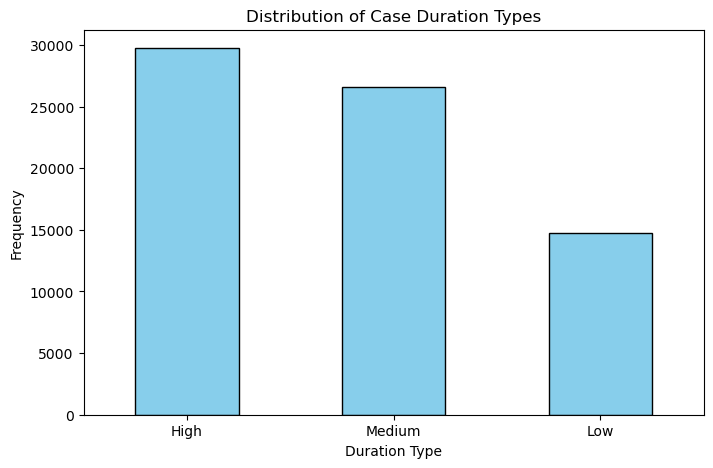

In [83]:
# Check the full distribution
import matplotlib.pyplot as plt

# Apply the categorization function
df["duration_type"] = df["case_duration"].apply(categorize_duration)
print(df["duration_type"].value_counts())

# Plot the distribution of categorized durations
plt.figure(figsize=(8, 5))
df["duration_type"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Case Duration Types")
plt.xlabel("Duration Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [84]:
# Count occurrences of each category in 'standard_cause'
standard_cause_counts = df['standard_cause'].value_counts()

# Print the counts
print(standard_cause_counts)

standard_cause
infringement                  44059
patent                        23412
declaratory judgment           2237
other                          1231
correction of inventorship       67
trademark                        65
breach of contract               12
copyright                         7
trade secret                      2
lanham act                        1
antitrust                         1
Name: count, dtype: int64


### BERT 

In [85]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

In [86]:
# set up tokenizer 
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") #This loads the pre-trained tokenizer for DistilBERT

# Label set up
LABEL_COLUMN = "standard_cause"
LABEL_VALUES = [
    'patent',
    'infringement',
    'other',
    'declaratory judgment',
    'breach of contract',
    'correction of inventorship',
    'trademark',
    'lanham act',
    'trade secret',
    'copyright',
    'antitrust'
]

# label map
label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i

# Input Features Class
class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, case_id, date, label):
        self.input_ids = input_ids        # Token IDs from tokenizer
        self.input_mask = input_mask      # Attention mask (1 for real tokens, 0 for padding)
        self.segment_ids = segment_ids    # Token type IDs 
        self.label_id = label_id          # Encoded integer label
        self.case_id = case_id        # unique ID for the case 
        self.date = date                  # date feature
        self.label = label                # original text label

# Input class 
class Input(object):
    def __init__(self, text, case_id, date, label=None, court=None, industry=None, 
                 case_duration=None, duration_type=None, number_patent=None, plaintiff=None, defendant=None, judge=None):
        self.text = text
        self.case_id = case_id
        self.date = date
        self.label = label
        self.court = court
        self.industry = industry
        self.case_duration = case_duration
        self.duration_type = duration_type
        self.number_patent = number_patent
        self.plaintiff = plaintiff
        self.defendant = defendant
        self.judge = judge
        

# Converting Input to Features
def convert_input(the_input, max_seq_length):
    tokens = tokenizer.tokenize(the_input.text)
    tokens.insert(0, '[CLS]')
    tokens.append('[SEP]')
    print("**{} tokens**\n{}\n".format(len(tokens), tokens))

    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True
    )

    input_ids = encode_plus_tokens["input_ids"]
    input_mask = encode_plus_tokens["attention_mask"]
    segment_ids = [0] * max_seq_length

    label_id = label_map[the_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        case_id=the_input.case_id,
        date=the_input.date,
        label=the_input.label,
    )

    return features

# Transforming Data to TFRecord
def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    records = []
    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()

        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        records.append(
            {
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "case_id": the_input.case_id,
                "date": the_input.date,
                "label": features.label,
                "court": the_input.court,
                "industry": the_input.industry,
                "case_duration": the_input.case_duration,
                "duration_type": the_input.duration_type,
                "number_patent": the_input.number_patent,
                "plaintiff": the_input.plaintiff,
                "defendant": the_input.defendant,
                "judge": the_input.judge
            }
        )

    tf_record_writer.close()

    return records



In [87]:
print(df.columns.tolist())

['flag', 'case_id', 'filed_date', 'filing_year', 'status', 'court', 'plaintiff', 'parent_company', '3rd_funded', 'defendant', 'patents', 'cause_of_action', 'entity_type', 'sme_annotation', 'industry', 'judge', 'closed_date', 'markman_hearing_date', 'product', 'case_duration', 'primary_cause', 'standard_cause', 'number_patent', 'patent', 'duration_type']


In [88]:
print(df["duration_type"].value_counts())

duration_type
High      29744
Medium    26601
Low       14749
Name: count, dtype: int64


#### Feature Store requires an Event Time Feature

In [89]:
from datetime import datetime
from time import strftime

# timestamp = datetime.now().replace(microsecond=0).isoformat()
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

# Set up a unique Autopilot job name for later
job_name = f"autopilot-patent-{timestamp}"
print(timestamp)


2025-04-03T06:07:14Z


#### Run BERT on Data

In [90]:
df = df.dropna(subset=['patents'])

In [91]:
import pandas as pd

# Or if you want to be more explicit about different null values
df = df[df['patents'].notna() & (df['patents'] != '')]

# Then apply the patent counting function
def count_patents(patents):
    # If patents is NaN or empty, return 0
    if pd.isna(patents) or patents == '':
        return 0
    
    # Convert to string to handle different input types
    patents_str = str(patents)
    
    # Count the number of '|' and add 1 to get the patent count
    # For "|5682318|6010156", this will return 2
    return patents_str.count('|') + 1

# Apply the function
df['number_patent'] = df['patents'].apply(count_patents)
# Original data


# Create DataFrame
df = pd.DataFrame(df, columns=["standard_cause", "number_patent", "cause_of_action", "case_id", "filed_date", "court", "industry","duration_type","case_duration",  "plaintiff", "defendant", "judge"])


# Generate full_text column dynamically
df["full_text"] = df["cause_of_action"] + " | " + df["court"] + " | " + df["industry"] + " | Number of Patents: " + df['number_patent'].astype(str)


# Define column names
LABEL_COLUMN = "standard_cause"
TEXT_COLUMN = "full_text"
CASE_ID_COLUMN = "case_id"
DATE_COLUMN = "filed_date"

# Use the Input class to create BERT input examples
inputs = df.apply(
    lambda x: Input(
        label=x[LABEL_COLUMN],
        text=x[TEXT_COLUMN],
        case_id=x[CASE_ID_COLUMN],        
        date=x[DATE_COLUMN],
        court=x["court"],
        industry=x["industry"],
        case_duration=x["case_duration"],
        duration_type=x["duration_type"],
        number_patent=x["number_patent"],
        plaintiff=x["plaintiff"],
        defendant=x["defendant"],
        judge=x["judge"]
    ),
    axis=1
).tolist()

# Check output
print(df.head())

   standard_cause  number_patent cause_of_action        case_id filed_date  \
1          patent              1          patent  1:00-cv-00001 2000-01-03   
5          patent              1          patent  1:00-cv-00003 2000-01-03   
7          patent              2          patent  3:00-cv-00004 2000-01-04   
10         patent              1          patent  1:00-cv-10004 2000-01-04   
21         patent              1          patent  3:00-cv-00032 2000-01-05   

                            court       industry duration_type  case_duration  \
1         Delaware District Court  Not Available          High          959.0   
5   Texas Southern District Court  Not Available          High          588.0   
7      Connecticut District Court  Not Available          High          359.0   
10   Massachusetts District Court  Not Available          High          329.0   
21          Oregon District Court  Not Available        Medium          134.0   

                     plaintiff  \
1   Becton

In [92]:
print(df["duration_type"].value_counts())

duration_type
High      29744
Medium    26601
Low       14749
Name: count, dtype: int64


#### Save TFRecords

In [93]:
import os

# Define the output directory and file path
output_dir = "./df-tfrecord-featurestore"
output_file = os.path.join(output_dir, "df.tfrecord")

# Get the absolute path of the file
absolute_path = os.path.abspath(output_file)

# Print out the details
print("Output Directory:", os.path.abspath(output_dir))
print("Output File Name:", "df.tfrecord")
print("Full Absolute Path:", absolute_path)
print("Does the directory exist?", os.path.exists(output_dir))
print("Current Working Directory:", os.getcwd())

Output Directory: /home/sagemaker-user/ADS508-Team4/df-tfrecord-featurestore
Output File Name: df.tfrecord
Full Absolute Path: /home/sagemaker-user/ADS508-Team4/df-tfrecord-featurestore/df.tfrecord
Does the directory exist? True
Current Working Directory: /home/sagemaker-user/ADS508-Team4


In [94]:
output_file = "./df-tfrecord-featurestore/df.tfrecord"

#### Add Features to SageMaker Feature Store

In [95]:
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

#### Create a feature group

In [96]:
from time import gmtime, strftime, sleep

feature_group_name = "data-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
print(feature_group_name)

data-feature-group-03-06-07-16


In [97]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="case_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="court", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="industry", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="case_duration", feature_type=FeatureTypeEnum.FRACTIONAL),
]


In [98]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)
print(feature_group)

FeatureGroup(name='data-feature-group-03-06-07-16', sagemaker_session=<sagemaker.session.Session object at 0x7fa92e821c10>, feature_definitions=[FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None), FeatureDefinition(feature_name='case_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='label', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None), FeatureDefinition(feature_name='split_type',

#### Set S3 Prefix for Offline Feature Store

In [99]:
# Specify record identifier and event time features
record_identifier_feature_name = "case_id"
event_time_feature_name = "date"

#Set S3 Prefix for Offline Feature Store
prefix = "data-feature-store-" + timestamp
print(prefix)

data-feature-store-2025-04-03T06:07:14Z


In [100]:
# create the feature group 
feature_group.create(
    s3_uri=f"s3://{bucket}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=False,
)


{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:632431441703:feature-group/data-feature-group-03-06-07-16',
 'ResponseMetadata': {'RequestId': '024c20a2-d11f-445c-b414-453cf31e79ab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '024c20a2-d11f-445c-b414-453cf31e79ab',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Thu, 03 Apr 2025 06:07:17 GMT'},
  'RetryAttempts': 0}}

#### Review the Records to Ingest into Feature Store 


In [ ]:
max_seq_length = 64
records = transform_inputs_to_tfrecord(inputs, output_file, max_seq_length)

#### Ingest Records into Feature Store 

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert records to DataFrame
df_records = pd.DataFrame.from_dict(records)

# Split data: 80% train, 20% temp (validation + test)
train_df, temp_df = train_test_split(df_records, test_size=0.20, random_state=42)

# Split temp data into 15% validation and 5% test
validation_df, test_df = train_test_split(temp_df, test_size=0.25, random_state=42)  # 0.25 * 20% = 5%

# Add the split type column
train_df["split_type"] = "train"
validation_df["split_type"] = "validation"
test_df["split_type"] = "test"

# Combine the splits into one DataFrame
df_records = pd.concat([train_df, validation_df, test_df], axis=0)

# Check the distribution
print(df_records["split_type"].value_counts())

# Print the head of the final DataFrame
print(df_records.head())

split_type
train         56875
validation    10664
test           3555
Name: count, dtype: int64
                                               input_ids  \
3519   [101, 7353, 1064, 4174, 2789, 2212, 2457, 1064...   
46887  [101, 20701, 1064, 4058, 2642, 2212, 2457, 106...   
43731  [101, 20701, 1064, 3146, 2789, 2212, 2457, 106...   
62626  [101, 11703, 8017, 14049, 8689, 1064, 4108, 26...   
48830  [101, 20701, 1064, 3516, 2670, 2212, 2457, 106...   

                                              input_mask  \
3519   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
46887  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
43731  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
62626  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
48830  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                             segment_ids  label_id  \
3519   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0   
46887  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### Cast DataFrame Object to Supported Feature Store Data Type String

In [103]:
print(df_records.dtypes)

input_ids                object
input_mask               object
segment_ids              object
label_id                  int64
case_id                  object
date             datetime64[ns]
label                    object
court                    object
industry                 object
case_duration           float64
duration_type            object
number_patent             int64
plaintiff                object
defendant                object
judge                    object
split_type               object
dtype: object


In [104]:
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

In [105]:
cast_object_to_string(df_records)

In [106]:
print(df_records.dtypes)

input_ids        string[python]
input_mask       string[python]
segment_ids      string[python]
label_id                  int64
case_id          string[python]
date             datetime64[ns]
label            string[python]
court            string[python]
industry         string[python]
case_duration           float64
duration_type    string[python]
number_patent             int64
plaintiff        string[python]
defendant        string[python]
judge            string[python]
split_type       string[python]
dtype: object


In [107]:
df_records.head()

,input_ids,input_mask,segment_ids,label_id,case_id,date,label,court,industry,case_duration,duration_type,number_patent,plaintiff,defendant,judge,split_type
3519,"[101, 7353, 1064, 4174, 2789, 2212, 2457, 1064...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2:03-cv-70810,2003-02-26,patent,Michigan Eastern District Court,Not Available,324.0,High,1,Nailco Group,"Ofer Specialties, Incorporated|Starshine Marke...",Denise Page Hood,train
46887,"[101, 20701, 1064, 4058, 2642, 2212, 2457, 106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1:15-cv-02077,2015-10-07,infringement,Ohio Northern District Court,O,160.0,Medium,2,Ourpets Co,Van Ness Plastic Molding Co Inc,Not Available,train
43731,"[101, 20701, 1064, 3146, 2789, 2212, 2457, 106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2:15-cv-00372,2015-03-13,infringement,Texas Eastern District Court,T,472.0,High,2,Script Security Solutions LLC,Comcast|Comcast Broadband Security LLC,Not Available,train
62626,"[101, 11703, 8017, 14049, 8689, 1064, 4108, 26...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,4:19-cv-00224,2019-09-27,declaratory judgment,Georgia Northern District Court,O,186.0,Medium,1,Wf Taylor LLC,Industrial Product Formulators Of America Inc,Not Available,train
48830,"[101, 20701, 1064, 3516, 2670, 2212, 2457, 106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0:16-cv-60359,2016-02-24,infringement,Florida Southern District Court,O,614.0,High,1,Atmos Nation LLC|Atmos Technology LLC,Laura Csomos|Jason Glowacki|David P Glowacki|G...,Not Available,train


In [108]:
df_records_short=df_records.head()

In [109]:
# df_records_short = df_records_short.dropna()

#### FUSION MODEL Final Data Preparation

#### Step 1: Load Pre-Trained BERT Model

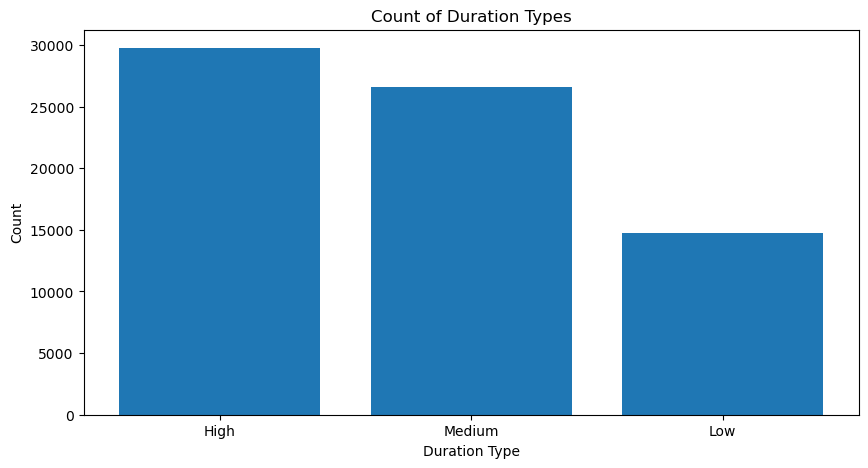

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume df_records is your DataFrame 
duration_type_counts = df_records['duration_type'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(duration_type_counts.index, duration_type_counts.values)
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.title('Count of Duration Types')

plt.show()

#### Step 2: Generate BERT Embeddings from Inputs

In [111]:
from transformers import TFDistilBertModel, DistilBertConfig

config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)

# Function to convert DataFrame records to numpy arrays
def prepare_bert_input(record):
    # Convert string representation of lists to actual lists of integers if needed
    input_ids = eval(record['input_ids']) if isinstance(record['input_ids'], str) else record['input_ids']
    input_mask = eval(record['input_mask']) if isinstance(record['input_mask'], str) else record['input_mask']
    segment_ids = eval(record['segment_ids']) if isinstance(record['segment_ids'], str) else record['segment_ids']
    
    # Ensure arrays have consistent length (max_seq_length)
    input_ids = input_ids[:max_seq_length] + [0] * (max_seq_length - len(input_ids))
    input_mask = input_mask[:max_seq_length] + [0] * (max_seq_length - len(input_mask))
    segment_ids = segment_ids[:max_seq_length] + [0] * (max_seq_length - len(segment_ids))
    
    return np.array(input_ids), np.array(input_mask), np.array(segment_ids)

# Generate embeddings for each record
def generate_bert_embeddings(df, bert_model, batch_size=32):
    all_embeddings = []
    
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Prepare batch inputs
        batch_input_ids = []
        batch_attention_mask = []
        batch_token_type_ids = []
        
        for _, record in batch.iterrows():
            input_ids, attention_mask, token_type_ids = prepare_bert_input(record)
            batch_input_ids.append(input_ids)
            batch_attention_mask.append(attention_mask)
            batch_token_type_ids.append(token_type_ids)
        
        # Convert to tensors
        input_ids_tensor = tf.convert_to_tensor(batch_input_ids, dtype=tf.int32)
        attention_mask_tensor = tf.convert_to_tensor(batch_attention_mask, dtype=tf.int32)
        token_type_ids_tensor = tf.convert_to_tensor(batch_token_type_ids, dtype=tf.int32)
        
        # Get BERT embeddings (using [CLS] token)
        outputs = bert_model(
            input_ids=input_ids_tensor,
            attention_mask=attention_mask_tensor
        )
        
        # Get [CLS] token embeddings (first token)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.extend(cls_embeddings)
        
        print(f"Processed batch {i//batch_size + 1}/{(len(df) + batch_size - 1)//batch_size}")
    
    return np.array(all_embeddings)

# Create embeddings
embeddings = generate_bert_embeddings(df_records, bert_model, batch_size=128)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Processed batch 1/556
Processed batch 2/556
Processed batch 3/556
Processed batch 4/556
Processed batch 5/556
Processed batch 6/556
Processed batch 7/556
Processed batch 8/556
Processed batch 9/556
Processed batch 10/556
Processed batch 11/556
Processed batch 12/556
Processed batch 13/556
Processed batch 14/556
Processed batch 15/556
Processed batch 16/556
Processed batch 17/556
Processed batch 18/556
Processed batch 19/556
Processed batch 20/556
Processed batch 21/556
Processed batch 22/556
Processed batch 23/556
Processed batch 24/556
Processed batch 25/556
Processed batch 26/556
Processed batch 27/556
Processed batch 28/556
Processed batch 29/556
Processed batch 30/556
Processed batch 31/556
Processed batch 32/556
Processed batch 33/556
Processed batch 34/556
Processed batch 35/556
Processed batch 36/556
Processed batch 37/556
Processed batch 38/556
Processed batch 39/556
Processed batch 40/556
Processed batch 41/556
Processed batch 42/556
Processed batch 43/556
Processed batch 44/5

#### Show Results

In [112]:
# Display the shape of the embeddings array
print("Embeddings shape:", embeddings.shape)

# Show the first embedding vector (first 10 values)
print("\nFirst embedding vector (first 10 values):")
print(embeddings[0][:10])

# Display a sample of embeddings
print("\nSample of first 3 embeddings (first 5 values each):")
for i in range(3):
    print(f"Record {i+1}:", embeddings[i][:5])

Embeddings shape: (71094, 768)

First embedding vector (first 10 values):
[-0.28692663  0.18829788 -0.178231   -0.12233471  0.16608943 -0.0474508
  0.18400612  0.03077888 -0.23117122 -0.1255661 ]

Sample of first 3 embeddings (first 5 values each):
Record 1: [-0.28692663  0.18829788 -0.178231   -0.12233471  0.16608943]
Record 2: [-0.24175844  0.19950098 -0.16708426 -0.06148075  0.12475346]
Record 3: [-0.179694    0.12996277 -0.1165026  -0.02343895  0.12509683]


#### Step 3: Prepare Metadata Features

In [113]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Fill missing values for plaintiff, defendant, and judge
df_records['plaintiff'] = df_records['plaintiff'].fillna("Unknown")
df_records['defendant'] = df_records['defendant'].fillna("Unknown")
df_records['judge'] = df_records['judge'].fillna("Unknown")

# Create encoders for categorical features
court_encoder = OneHotEncoder(sparse_output=False)
industry_encoder = OneHotEncoder(sparse_output=False)
judge_encoder     = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform categorical features
court_encoded = court_encoder.fit_transform(df_records[['court']])
industry_encoded = industry_encoder.fit_transform(df_records[['industry']])
judge_encoded     = judge_encoder.fit_transform(df_records[['judge']])

# Normalize numerical features
scaler = StandardScaler()
number_patent_scaled = scaler.fit_transform(df_records[['number_patent']])

#### Step 4: Combine BERT Embedding with Metadata (Fusion)

In [114]:
# Combine all features for the fusion model
X_combined = np.hstack([
    embeddings,                 # BERT embeddings
    court_encoded,              # One-hot encoded courts
    industry_encoded,           # One-hot encoded industries
    number_patent_scaled,        # Scaled number of patents
    judge_encoded,              # One-hot encoded judges
    
])

# Prepare the target variable (duration_type)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_records['duration_type'])  # Convert 'low', 'medium', 'high' to 0, 1, 2

# Split data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

In [115]:
from sklearn.utils import class_weight

# Compute class weights based on the training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [116]:
# Print the shape of the combined features
print("Shape of combined features (X_combined):", X_combined.shape)

# Print the first few rows
print("\nFirst few rows of combined features:")
print(X_combined[:5])

# Get more detailed information about the features
print("\nFeature composition:")
print(f"BERT Embeddings: {embeddings.shape}")
print(f"Court Encoded: {court_encoded.shape}")
print(f"Industry Encoded: {industry_encoded.shape}")
print(f"Number Patent Scaled: {number_patent_scaled.shape}")

# If you want to understand the total features
total_features = (
    embeddings.shape[1] + 
    court_encoded.shape[1] + 
    industry_encoded.shape[1] + 
    number_patent_scaled.shape[1]
)
print(f"\nTotal number of features: {total_features}")

# Print the unique classes in the target variable
print("\nUnique classes in duration_type:")
print(label_encoder.classes_)
print("Encoded classes:", np.unique(y))

Shape of combined features (X_combined): (71094, 2953)

First few rows of combined features:
[[-0.28692663  0.18829788 -0.178231   ...  0.          0.
   0.        ]
 [-0.24175844  0.19950098 -0.16708426 ...  0.          0.
   0.        ]
 [-0.179694    0.12996277 -0.1165026  ...  0.          0.
   0.        ]
 [-0.22096245  0.04802689 -0.19672854 ...  0.          0.
   0.        ]
 [-0.19000043  0.14218707 -0.10593857 ...  0.          0.
   0.        ]]

Feature composition:
BERT Embeddings: (71094, 768)
Court Encoded: (71094, 103)
Industry Encoded: (71094, 4)
Number Patent Scaled: (71094, 1)

Total number of features: 876

Unique classes in duration_type:
['High' 'Low' 'Medium']
Encoded classes: [0 1 2]


#### Step 5: Build and Train the Fusion Model

In [117]:
from sklearn.utils import class_weight


# Build the fusion model
fusion_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_combined.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: low, medium, high
])

fusion_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = fusion_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights  
)

# Evaluate the model
loss, accuracy = fusion_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10


2025-04-03 06:53:45.031029: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671807500 exceeds 10% of free system memory.


1778/1778 [==============================] - 7s 4ms/step - loss: 1.0314 - accuracy: 0.4585 - val_loss: 1.0091 - val_accuracy: 0.5151
Epoch 2/10
1778/1778 [==============================] - 6s 4ms/step - loss: 0.9998 - accuracy: 0.4917 - val_loss: 1.0179 - val_accuracy: 0.4896
Epoch 3/10
1778/1778 [==============================] - 6s 4ms/step - loss: 0.9899 - accuracy: 0.5011 - val_loss: 0.9945 - val_accuracy: 0.5031
Epoch 4/10
1778/1778 [==============================] - 6s 4ms/step - loss: 0.9862 - accuracy: 0.4992 - val_loss: 0.9593 - val_accuracy: 0.5254
Epoch 5/10
1778/1778 [==============================] - 7s 4ms/step - loss: 0.9820 - accuracy: 0.5032 - val_loss: 0.9644 - val_accuracy: 0.5154
Epoch 6/10
1778/1778 [==============================] - 6s 4ms/step - loss: 0.9806 - accuracy: 0.5065 - val_loss: 0.9708 - val_accuracy: 0.5313
Epoch 7/10
1778/1778 [==============================] - 6s 4ms/step - loss: 0.9795 - accuracy: 0.5090 - val_loss: 0.9815 - val_accuracy: 0.5211
Epo

#### Visualize Training History

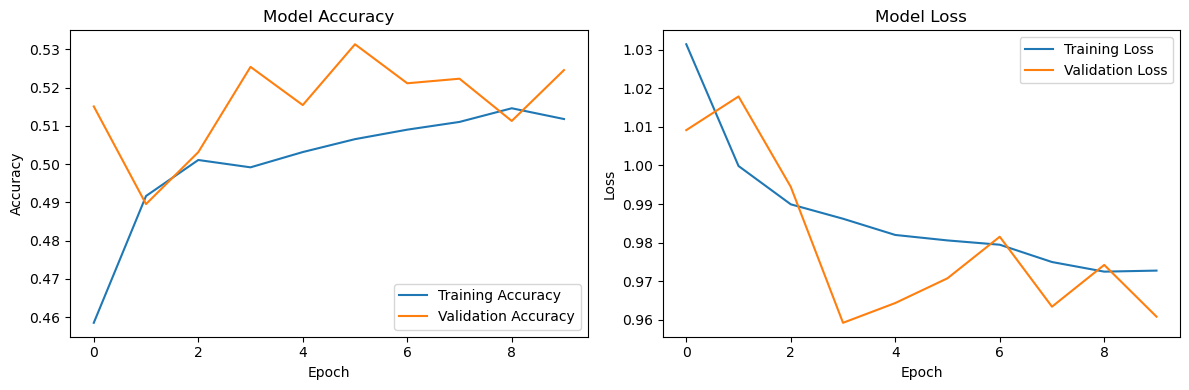

445/445 [==============================] - 1s 1ms/step
Macro F1-score: 0.5001767436958938

Classification Report:
              precision    recall  f1-score   support

        High       0.57      0.69      0.62      6010
         Low       0.46      0.43      0.44      2915
      Medium       0.49      0.39      0.44      5294

    accuracy                           0.52     14219
   macro avg       0.51      0.50      0.50     14219
weighted avg       0.52      0.52      0.52     14219



In [118]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Macro F1-score:", f1_score(y_test, y_pred_classes, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

#### Confusion Matrix

445/445 [==============================] - 1s 1ms/step
Confusion Matrix:
[[4145  634 1231]
 [ 787 1248  880]
 [2374  854 2066]]

Confusion Matrix Breakdown:
Rows represent actual classes
Columns represent predicted classes

Detailed Confusion Matrix:
Actual High: [4145  634 1231]
Actual Low: [ 787 1248  880]
Actual Medium: [2374  854 2066]


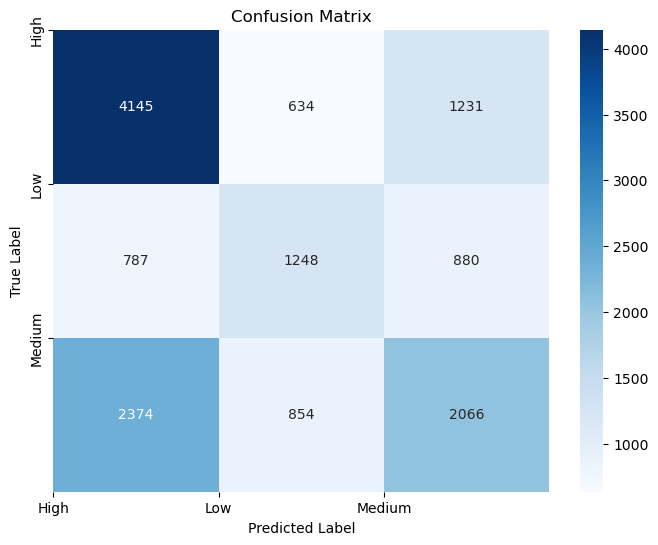

In [119]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print("Rows represent actual classes")
print("Columns represent predicted classes")

# If you want to see with class labels
print("\nDetailed Confusion Matrix:")
for i, actual_class in enumerate(label_encoder.classes_):
    row = cm[i]
    print(f"Actual {actual_class}: {row}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(np.arange(3), label_encoder.classes_)
plt.yticks(np.arange(3), label_encoder.classes_)
plt.show()

#### No Embedding for Prediction

Epoch 1/10
1778/1778 [==============================] - 4s 2ms/step - loss: 1.0056 - accuracy: 0.4804 - val_loss: 0.9889 - val_accuracy: 0.4947
Epoch 2/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9954 - accuracy: 0.4897 - val_loss: 0.9884 - val_accuracy: 0.4914
Epoch 3/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9941 - accuracy: 0.4889 - val_loss: 0.9896 - val_accuracy: 0.4875
Epoch 4/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9921 - accuracy: 0.4921 - val_loss: 0.9882 - val_accuracy: 0.4922
Epoch 5/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9907 - accuracy: 0.4934 - val_loss: 0.9875 - val_accuracy: 0.4951
Epoch 6/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9897 - accuracy: 0.4948 - val_loss: 0.9878 - val_accuracy: 0.4948
Epoch 7/10
1778/1778 [==============================] - 3s 2ms/step - loss: 0.9886 - accuracy: 0.4940 - val_loss: 0.9882 - val_accuracy:

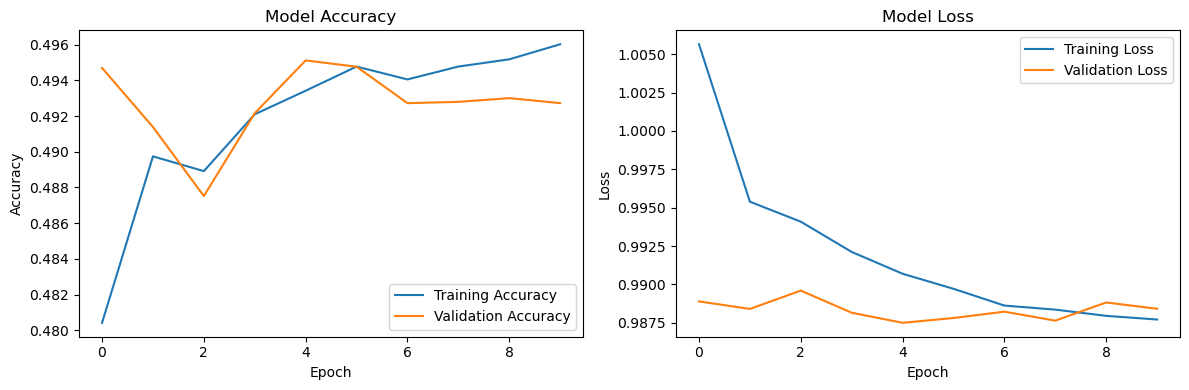

445/445 [==============================] - 0s 885us/step

Classification Report:
              precision    recall  f1-score   support

        High       0.52      0.78      0.62      6010
         Low       0.44      0.15      0.23      2915
      Medium       0.44      0.35      0.39      5294

    accuracy                           0.49     14219
   macro avg       0.47      0.43      0.41     14219
weighted avg       0.48      0.49      0.46     14219



In [120]:
# Combine features without BERT embeddings
X_combined = np.hstack([
    court_encoded,              # One-hot encoded courts
    industry_encoded,           # One-hot encoded industries
    number_patent_scaled        # Scaled number of patents
])

# Prepare the target variable (duration_type)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_records['duration_type'])  # Convert 'low', 'medium', 'high' to 0, 1, 2

# Split data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Build the fusion model
fusion_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_combined.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: low, medium, high
])

fusion_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = fusion_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

# Evaluate the model
loss, accuracy = fusion_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
from sklearn.metrics import classification_report
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

#### Confusion Matrix Values

445/445 [==============================] - 0s 879us/step
Confusion Matrix:
[[4695  223 1092]
 [1232  440 1243]
 [3097  326 1871]]

Confusion Matrix Breakdown:
Rows represent actual classes
Columns represent predicted classes

Detailed Confusion Matrix:
Actual High: [4695  223 1092]
Actual Low: [1232  440 1243]
Actual Medium: [3097  326 1871]


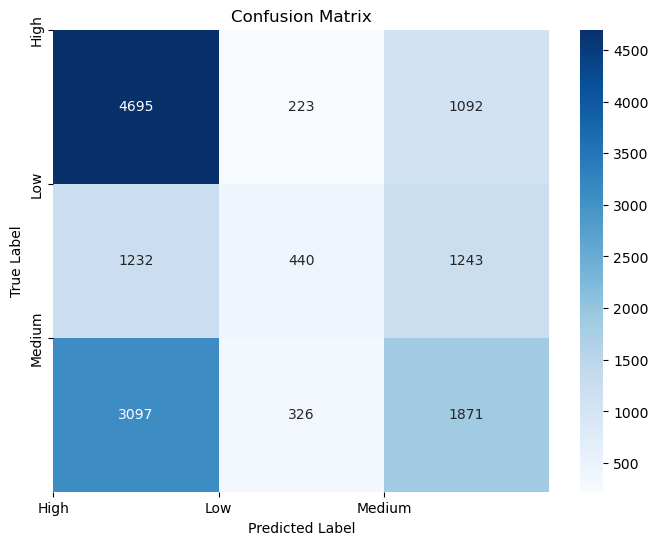

In [121]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print("Rows represent actual classes")
print("Columns represent predicted classes")

# If you want to see with class labels
print("\nDetailed Confusion Matrix:")
for i, actual_class in enumerate(label_encoder.classes_):
    row = cm[i]
    print(f"Actual {actual_class}: {row}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(np.arange(3), label_encoder.classes_)
plt.yticks(np.arange(3), label_encoder.classes_)
plt.show()